### EMA and strategy backtest by vectorbt

In [238]:
import time
from datetime import datetime
import vectorbt as vbt

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

In [239]:
data = pd.read_csv('BTCUSDT_1d_2022_01_04.csv')
data.tail()

,timestamp,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
1457,1640649600000,50701.44,50704.05,47313.01,47543.74,45853.33924,1640735999999,2.242102e+09,1345774,21743.17013,1.063172e+09,0
1458,1640736000000,47543.74,48139.08,46096.99,46464.66,39498.87000,1640822399999,1.873786e+09,1114074,19089.61910,9.059697e+08,0
1459,1640822400000,46464.66,47900.00,45900.00,47120.87,30352.29569,1640908799999,1.428756e+09,910157,14886.52375,7.007923e+08,0
1460,1640908800000,47120.88,48548.26,45678.00,46216.93,34937.99796,1640995199999,1.650716e+09,1059783,17315.54230,8.183317e+08,0
1461,1640995200000,46216.93,47954.63,46208.37,47722.65,19604.46325,1641081599999,9.241552e+08,714899,9942.36679,4.687387e+08,0


In [240]:
df = data.copy()

### Create strategy

In [241]:
ema_rsi = ta.Strategy(
    name = 'EMA and RSI',
    description = 'EMA amd RSI',
    ta = [
        {'kind': 'rsi', 'length': 14},
        {'kind': 'ema', 'length': 15},
        {'kind': 'ema', 'length': 30},
    ]
)

### Create signal

In [242]:
class BacktestEMAandRsi:
    def __init__(self, params):
        self.orders = pd.DataFrame(columns = ['timestamp', 'entries', 'exits', 'action'])
        self.order = {'action': None, 'entries': None, 'exits': None, 'timestamp': None, 'T/P': None, 'S/L': None}
        self.unknow_result = []
        
        self.current_action = 'close'
        self.rsi = params['rsi']
        self.ema_1 = params['ema_1']
        self.ema_2 = params['ema_2']
        
        self.atr = params['atr']
        self.overbought = params['overbought']
        self.oversold = params['oversold']
        
        self.pip_value = params['pip_value']
        self.rr = params['rr']
        self.df = params['df']
        self.bars_status = 'idle' # idle, break_high, break_low, oversold, overbought
        
    def reset_order(self):
        self.order = {'action': None, 'entries': None, 'exits': None, 'timestamp': None, 'T/P': None, 'S/L': None}
  
    def append_null_order(self, row):
        self.order['timestamp'] = row['timestamp']
        self.order['entries'] = False
        self.order['exits'] = False
        self.orders = self.orders.append(self.order, ignore_index = True)

    def check_trend(self, row):
        if row['EMA_' + str(self.ema_1)] > row['EMA_' + str(self.ema_2)]:
            self.bars_status = 'up_trend'
#         elif row['EMA_' + str(self.ema_1)] < row['EMA_' + str(self.ema_2)]:
#             self.bars_status = 'down_trend'

    def check_breakout(self, row):
        if row['EMA_' + str(self.ema_2)] > row['low']:
            self.bars_status = 'break_low' 
            
    def check_over_rsi(self, row):
        if row['RSI_' + str(self.rsi)] > self.overbought:
            self.bars_status = 'overbought'
#         if row['RSI_' + str(self.rsi)] < self.oversold:
#             self.bars_status = 'oversold'

    def backtest(self):
        ema_rsi = ta.Strategy(
            name = 'EMA and RSI',
            description = 'EMA amd RSI',
            ta = [
                {'kind': 'rsi', 'length': self.rsi},
                {'kind': 'ema', 'length': self.ema_1},
                {'kind': 'ema', 'length': self.ema_2},
                {'kind': 'atr', 'length': self.atr},
            ]
        )
        self.df.ta.strategy(ema_rsi)
        self.df = self.df.copy().dropna()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], unit='ms')
        
        for index, row in self.df.iterrows():
            entry = 0
            
            if self.current_action == 'close':
                if self.bars_status == 'idle':
                    self.check_trend(row)
                    
                if self.bars_status == 'up_trend':
#                     self.check_breakout(row)
                    self.check_over_rsi(row)
                    
#                 if self.bars_status == 'break_low':
#                     self.check_over_rsi(row)
#                     print(row.index)
                    
                if (self.bars_status == 'overbought'):
#                     if (row['RSI_' + str(self.rsi)]) > self.oversold:
                    self.bars_status = 'idle'
                    row['action'] = 'buy'
                    self.order['action'] = 'buy'
                    self.order['timestamp'] = row['timestamp']

                    self.order['entries'] = True
                    self.order['exits'] = False
                    self.order['S/L'] = row['close'] - row['ATRr_'+str(self.atr)]
                    self.order['T/P'] = row['close'] + (self.rr * abs(row['close'] - self.order['S/L']))

                    self.orders = self.orders.append(self.order, ignore_index = True)
                    self.current_action = 'buy'
                    
#                     else:
#                         self.append_null_order(row)
                    
                else:
                    self.append_null_order(row)
        
            elif self.current_action == 'buy':
                if row['low'] <= self.order['S/L'] or (row['high'] >= self.order['T/P']) :
                    self.order['timestamp'] = row['timestamp']
                    self.order['entries'] = False
                    self.order['exits'] = True
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    self.reset_order()
                    
                else:
                    self.append_null_order(row)
            else:
                self.append_null_order(row)

        return self.orders

In [243]:
df = data.copy()

### Prepare Result

In [244]:
pair = BacktestEMAandRsi({
    'atr': 14,
    'ema_1': 15,
    'ema_2': 30,
    'rsi': 14,
    'pip_value': 0.001,
    'rr': 1.5,
    'df': df,
    'overbought': 70,
    'oversold': 30,
})
signals = pair.backtest()
signals = signals.set_index('timestamp')
signals

,entries,exits,action,S/L,T/P
timestamp,,,,,
2018-01-30,False,False,None,NaN,NaN
2018-01-31,False,False,None,NaN,NaN
2018-02-01,False,False,None,NaN,NaN
2018-02-02,False,False,None,NaN,NaN
2018-02-03,False,False,None,NaN,NaN
...,...,...,...,...,...
2021-12-28,False,False,None,NaN,NaN
2021-12-29,False,False,None,NaN,NaN
2021-12-30,False,False,None,NaN,NaN


In [245]:
df = df.copy().dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.set_index('timestamp')
df

,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore,RSI_14,EMA_15,EMA_30,ATRr_14
timestamp,,,,,,,,,,,,,,,
2018-01-30,11250.11,11308.42,9900.00,10237.51,25554.372946,1517356799999,2.689783e+08,259212,11388.096419,1.198643e+08,0,36.594241,11664.748726,12977.211333,1520.815131
2018-01-31,10230.00,10425.85,9700.00,10285.10,18015.956805,1517443199999,1.816442e+08,201422,8782.584442,8.860927e+07,0,37.007246,11492.292635,12803.526731,1457.138400
2018-02-01,10285.10,10335.00,8750.99,9224.52,33564.764311,1517529599999,3.176363e+08,316020,15430.003849,1.461307e+08,0,32.004081,11208.821056,12572.623071,1467.213453
2018-02-02,9224.52,9250.00,8010.02,8873.03,49971.626975,1517615999999,4.342365e+08,453411,23113.503584,2.012927e+08,0,30.530914,10916.847174,12333.939647,1449.311432
2018-02-03,8873.03,9473.01,8229.00,9199.96,28725.000735,1517702399999,2.568347e+08,327519,14182.838146,1.270686e+08,0,33.592796,10702.236277,12131.747412,1433.255345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,50701.44,50704.05,47313.01,47543.74,45853.339240,1640735999999,2.242102e+09,1345774,21743.170130,1.063172e+09,0,40.655289,49409.030062,50717.822043,2535.001694
2021-12-29,47543.74,48139.08,46096.99,46464.66,39498.870000,1640822399999,1.873786e+09,1114074,19089.619100,9.059697e+08,0,37.987915,49040.983804,50443.424492,2499.793716
2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.295690,1640908799999,1.428756e+09,910157,14886.523750,7.007923e+08,0,40.542652,48800.969579,50229.066137,2464.094165


In [246]:
signals[signals['entries'] == True]

,entries,exits,action,S/L,T/P
timestamp,,,,,
2018-07-23,True,False,buy,7391.281702,8215.602447
2018-07-25,True,False,buy,7807.380488,8728.029268
2019-02-18,True,False,buy,3786.727843,4066.408235
2019-04-02,True,False,buy,4722.715456,5059.151816
2019-04-04,True,False,buy,4729.313837,5152.679245
2019-04-07,True,False,buy,4992.400998,5437.073502
2019-04-14,True,False,buy,4936.086728,5424.119908
2019-04-24,True,False,buy,5230.243090,5692.135366
2019-05-03,True,False,buy,5580.611810,6060.807285


### Backtest

In [247]:
port = vbt.Portfolio.from_signals(df.close,
                                  entries=signals.entries.astype('bool'),
                                  exits=signals.exits.astype('bool'),
                                  freq="D",
                                  init_cash=100,
                                  fees=0.0025,
                                  slippage=0.0025
                                 )

In [248]:
port.plot().show()

In [249]:
port.stats()

Start                               2018-01-30 00:00:00
End                                 2022-01-01 00:00:00
Period                               1433 days 00:00:00
Start Value                                       100.0
End Value                                    172.536696
Total Return [%]                              72.536696
Benchmark Return [%]                         366.154856
Max Gross Exposure [%]                            100.0
Total Fees Paid                               34.044369
Max Drawdown [%]                              30.128553
Max Drawdown Duration                 602 days 00:00:00
Total Trades                                         55
Total Closed Trades                                  55
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  50.909091
Best Trade [%]                                15.031482
Worst Trade [%]                              -14

<AxesSubplot:xlabel='timestamp'>

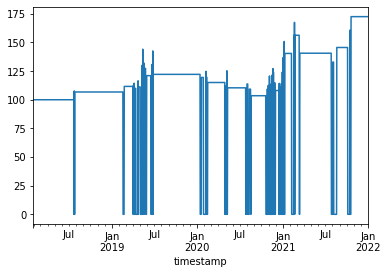

In [250]:
port.cash().plot()

<AxesSubplot:xlabel='timestamp'>

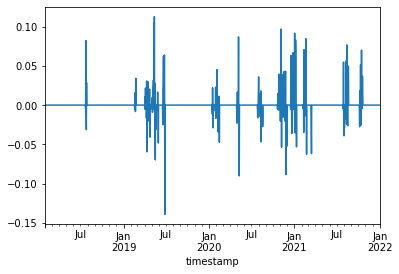

In [251]:
port.daily_returns().plot()

<AxesSubplot:ylabel='Frequency'>

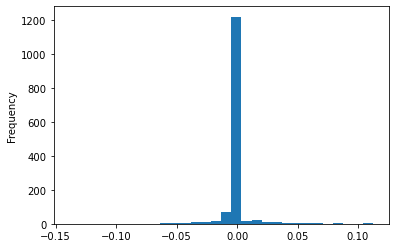

In [252]:
port.daily_returns().plot(kind='hist', bins=30)